# **Context**

The file contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself. The data structure was inherited from Disasters on social media

The tweets were collected on Jan 14th, 2020.

Some of the topics people were tweeting:

    The eruption of Taal Volcano in Batangas, Philippines
    Coronavirus
    Bushfires in Australia
    Iran downing of the airplane flight PS752

Disclaimer: The dataset contains text that may be considered profane, vulgar, or offensive

# Reading the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.fasttext import FastText
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import warnings
import os
import pickle
import re

warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
sns.set_palette("pastel")

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IAmAlight\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\IAmAlight\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IAmAlight\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IAmAlight\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
ARTIFACTS_DIR = os.path.join(os.path.dirname(os.getcwd()), 'artifacts')
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')

if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [ ]:
df = pd.read_csv(os.path.join(DATA_DIR, 'tweets.csv'))
df.sample(10)

,id,keyword,location,text,target
1946,1946,bush%20fires,West Sussex.,It’s very clear. Like the bush Fires climate c...,0
10578,10578,tsunami,NaN,BREAKING: no tsunami watch or warning followin...,1
8956,8956,screaming,fuck off,always screaming and she thinks its cool to swear,0
2730,2730,crashed,"California, USA",Should put this pic side-by-side with one that...,0
7514,7514,military,NaN,#InTheNews: Nigerien president sacks army chie...,1
1051,1051,blew%20up,Bandra Mumbai,True. The same believers of the same false god...,0
6514,6514,hijacking,NaN,To me the saddest part of this campaign so far...,0
8081,8081,panic,Myoi’s,"Old but gold...satzu moments.. jealous, persua...",0
10439,10439,traumatised,NaN,Parents and carers are faced with the responsi...,1
921,921,blazing,USA 🇺🇸,The list goes on..... All these folks have sta...,0


# Data Wrangling

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [121]:
# Check for missing values
df.isna().mean() * 100

,0
id,0.000000
keyword,0.000000
location,30.061566
text,0.000000
target,0.000000


In [122]:
#check for duplicates
df.duplicated(subset=["text"]).sum()

147

In [123]:
#remove duplicates
df = df.drop_duplicates(subset=["text"],keep=False)

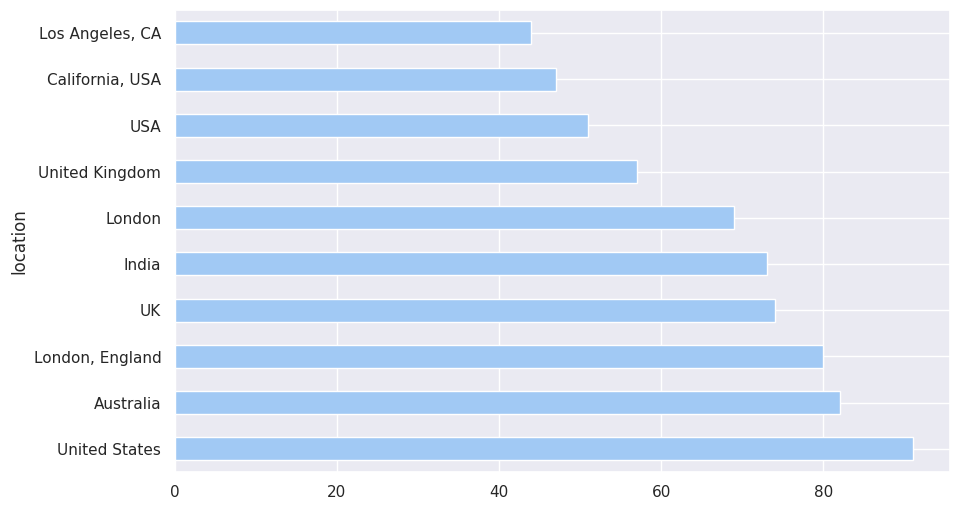

In [124]:
df["location"].value_counts().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 6))
plt.show()

In [125]:
df = df.drop(columns=["id", "location"])

# EDA

In [126]:
df.describe(include='all')

,keyword,text,target
count,11078,11078,11078.000000
unique,219,11078,NaN
top,thunderstorm,Jake Corway wrecked while running 14th at IRP.,NaN
freq,91,1,NaN
mean,NaN,NaN,0.182885
std,NaN,NaN,0.386590
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


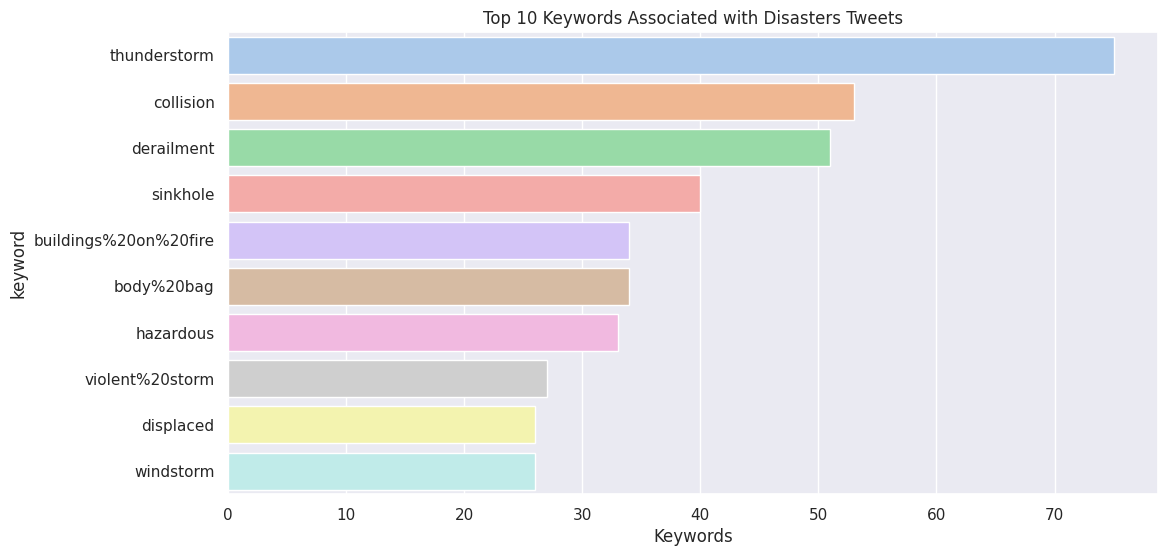

In [127]:
# Keywords associated with disaster tweets
keywords_disaster = df[df['target']==1]['keyword'].value_counts().head(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=keywords_disaster, y='keyword', x='count',hue='keyword')
plt.title('Top 10 Keywords Associated with Disasters Tweets')
plt.xlabel('Keywords')
plt.show()

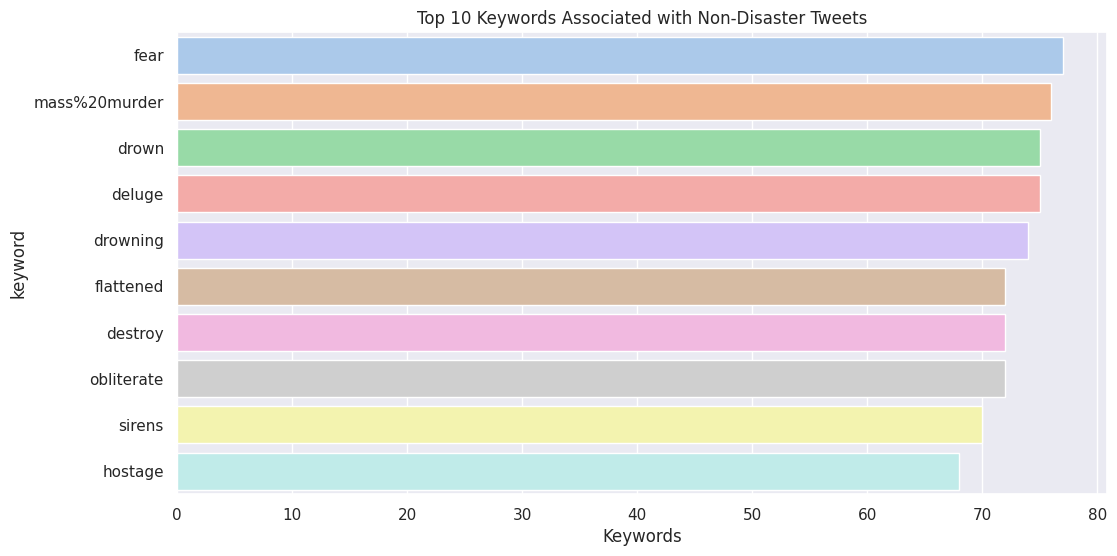

In [128]:
# Keywords associated with non-disaster tweets
keywords_notdisaster = df[df['target']==0]['keyword'].value_counts().head(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=keywords_notdisaster, y='keyword', x='count',hue='keyword')
plt.title('Top 10 Keywords Associated with Non-Disaster Tweets')
plt.xlabel('Keywords')
plt.show()

In [129]:
def hashtag_extract(t):
    hashtags = []
    for i in t:
        h = re.findall(r"(#\w+)",i)
        hashtags.append(h)
    return sum(hashtags, [])

In [130]:
#extract hashtags from disaster and non-disaster tweets
disaster_hashtags = hashtag_extract(df[df['target']==1]['text'])
notdisaster_hashtags = hashtag_extract(df[df['target']==0]['text'])

len(np.unique(disaster_hashtags)), len(np.unique(notdisaster_hashtags))

(420, 1457)

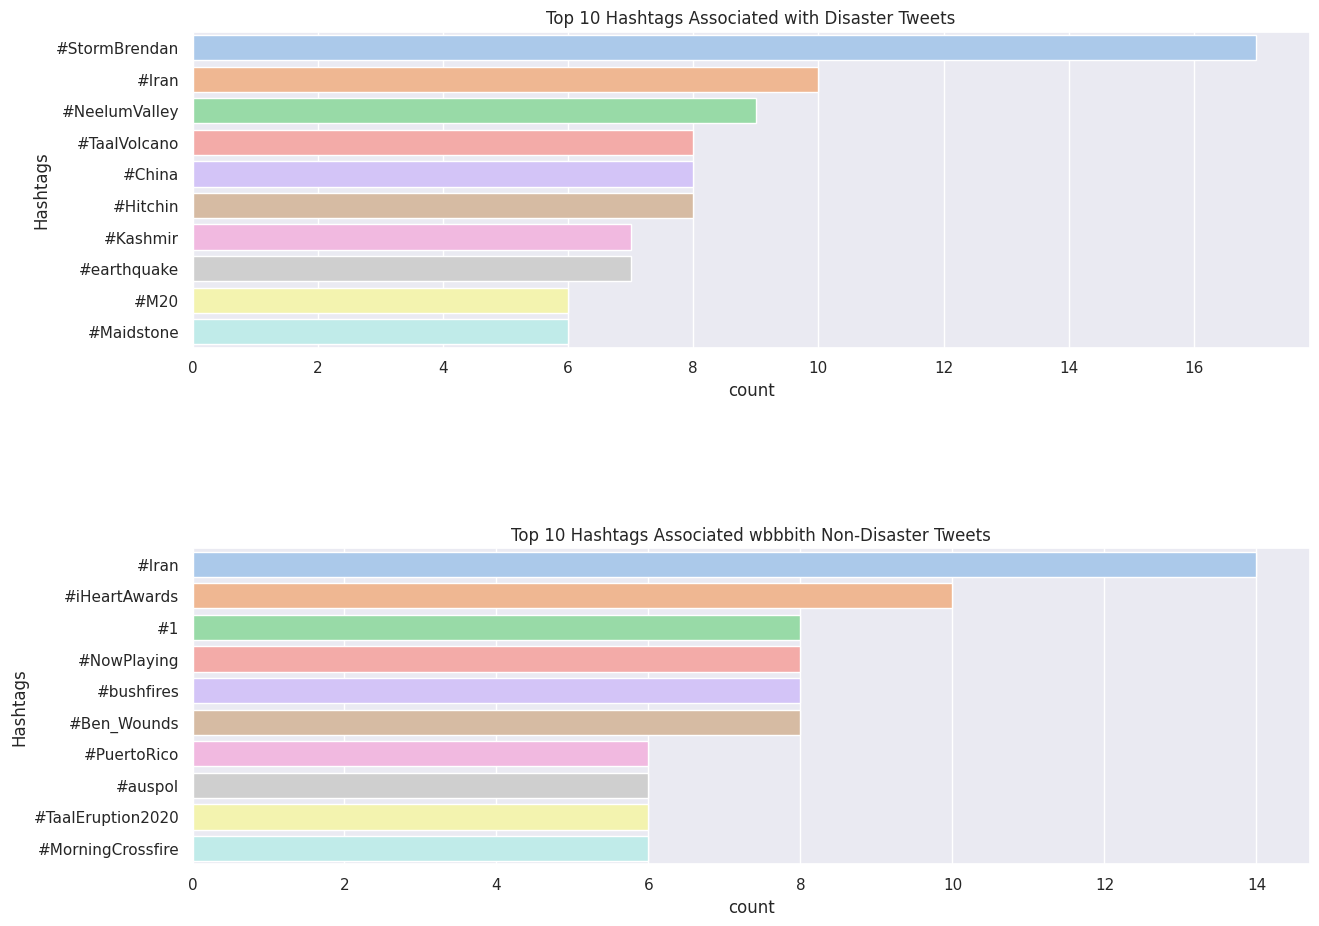

In [131]:
top10_disaster_hashtags = pd.Series(disaster_hashtags).value_counts().head(10)
top10_notdisaster_hashtags = pd.Series(notdisaster_hashtags).value_counts().head(10)


fig,axes = plt.subplots(2, 1, figsize=(15, 12))
fig.tight_layout(pad=10.0)

plt.sca(axes[0])
sns.barplot(data=top10_disaster_hashtags.reset_index(), y='index', x='count',hue='index')
plt.title('Top 10 Hashtags Associated with Disaster Tweets')
plt.ylabel('Hashtags')

plt.sca(axes[1])
sns.barplot(data = top10_notdisaster_hashtags.reset_index(), y='index', x='count',hue='index')
plt.title('Top 10 Hashtags Associated wbbbith Non-Disaster Tweets')
plt.ylabel('Hashtags')
plt.show()

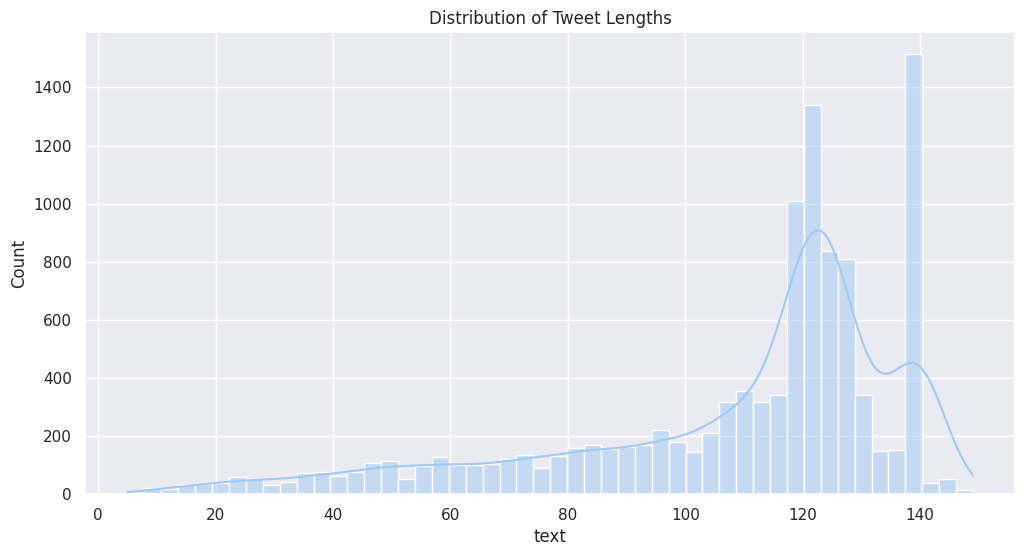

In [132]:
#plot the length of tweets
tweets_len = df['text'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(tweets_len, bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

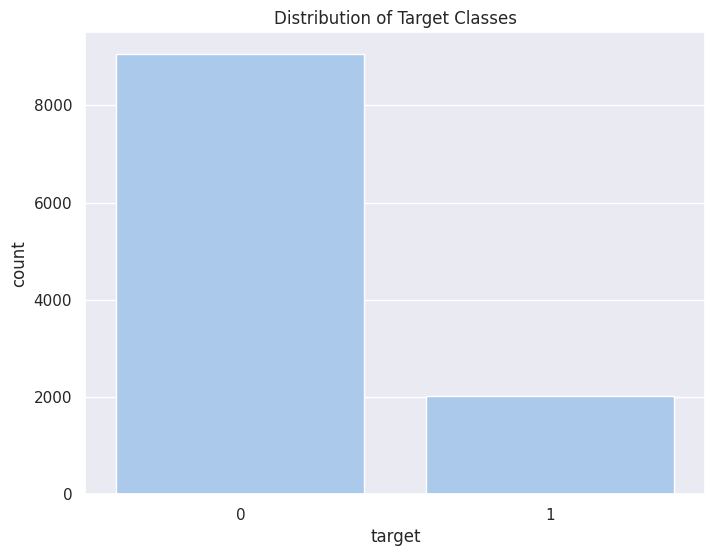

In [133]:
# Visualize the distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='target')
plt.title('Distribution of Target Classes')
plt.show()

# Text preprocessing and WordCloud

In [134]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Replace emoticons
    text = replace_emoticons(text)

    # Replace contractions
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'m", " am", text)

    # Extract hashtags as special tokens
    hashtags = re.findall(r'#\w+', text)
    hashtag_tokens = [tag[1:] for tag in hashtags]  # Remove '#' symbol

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove @user tags
    text = re.sub(r'@\w+', '', text)

    # Remove specific punctuation but keep apostrophes for contractions
    text = re.sub(r'[^\w\s\']', ' ', text)

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Reduce repeated characters (e.g., helloooo → helloo)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor', 'none', 'never'}
    tokens = [word for word in tokens if word not in stop_words]

    # Remove short words
    tokens = [word for word in tokens if len(word) >= 2]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Add back hashtag tokens
    tokens.extend(hashtag_tokens)

    return ' '.join(tokens)


def replace_emoticons(text):
    emoticon_dict = {
        ":)": "Happy",
        ":(": "Sad",
        ":D": "Very Happy",
        ":|": "Neutral",
        ":O": "Surprised",
        "<3": "Love",
        ";)": "Wink",
        ":P": "Playful",
        ":/": "Confused",
        ":*": "Kiss",
        ":')": "Touched",
        "XD": "Laughing",
        ":3": "Cute",
        ">:(": "Angry",
        ":-O": "Shocked",
        ":|]": "Robot",
        ":>": "Sly",
        "^_^": "Happy",
        "O_o": "Confused",
        ":-|": "Straight Face",
        ":X": "Silent",
        "B-)": "Cool",
        "<(‘.'<)": "Dance",
        "(-_-)": "Bored",
        "(>_<)": "Upset",
        "(¬‿¬)": "Sarcastic",
        "(o_o)": "Surprised",
        "(o.O)": "Shocked",
        ":0": "Shocked",
        ":*(": "Crying",
        ":v": "Pac-Man",
        "(^_^)v": "Double Victory",
        ":-D": "Big Grin",
        ":-*": "Blowing a Kiss",
        ":^)": "Nosey",
        ":-((": "Very Sad",
        ":-(": "Frowning",
    }

    # Escape characters for regex
    for emoticon, word in emoticon_dict.items():
        pattern = re.escape(emoticon)
        text = re.sub(pattern, word, text)

    return text



In [135]:
df

,keyword,text,target
0,ablaze,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...
11365,wrecked,Media should have warned us well in advance. T...,0
11366,wrecked,i feel directly attacked 💀 i consider moonbin ...,0
11367,wrecked,i feel directly attacked 💀 i consider moonbin ...,0
11368,wrecked,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [136]:
#preprocess the text column
df['text'] = df['text'].apply(preprocess_text)
df.to_csv(os.path.join(DATA_DIR, 'tweets_preprocessed.csv'), index=False)

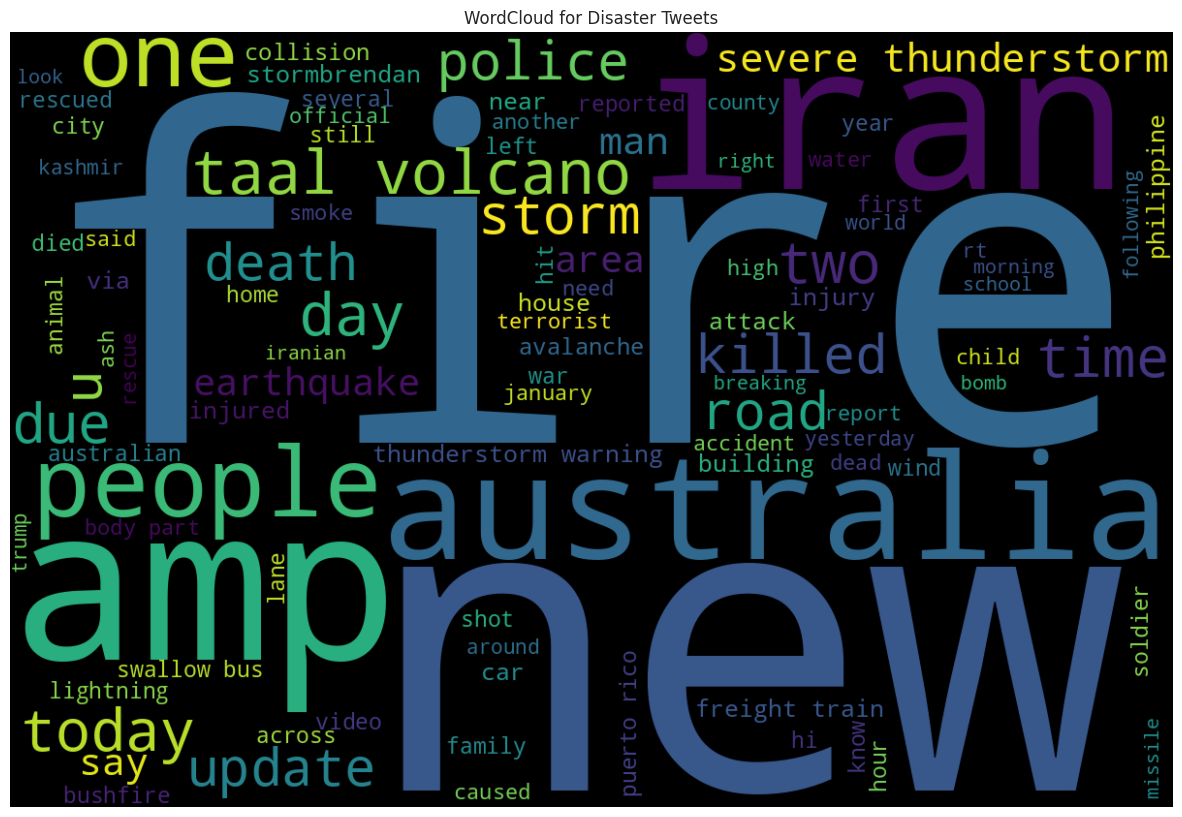

In [137]:
#wordcloud for disaster tweets
plt.figure(figsize=(15, 12))
wc = WordCloud(width=1200,height=800,max_words=100,colormap='viridis').generate(' '.join(df[df['target']==1]['text']))
plt.title('WordCloud for Disaster Tweets')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

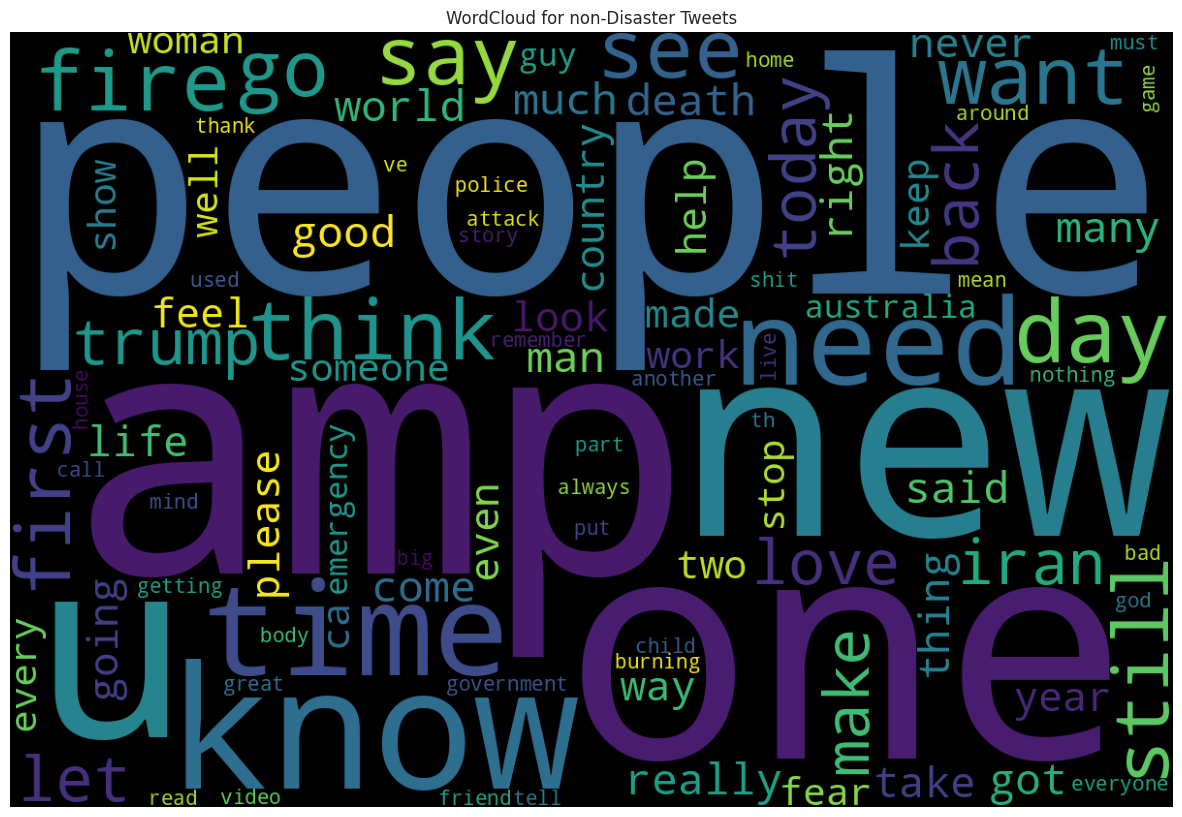

In [138]:
#wordcloud for non-disaster tweets
plt.figure(figsize=(15, 12))
wc = WordCloud(width=1200,height=800,max_words=100,colormap='viridis').generate(' '.join(df[df['target']==0]['text']))
plt.title('WordCloud for non-Disaster Tweets')
plt.imshow(wc)
plt.axis('off')
plt.show()

# Configuration

In [139]:
EMBED_DIM = 128
SEQ_LEN = 100
MAX_WORDS = 5000

BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 2

# RNN with GLove

In [140]:
#vectorize the text data using glove
X_glove = [
    [nlp.vocab[token].vector if token in nlp.vocab and nlp.vocab[token].has_vector else np.zeros(300) for token in token_list]
    for token_list in df['text']
           ]
y= df['target'].values


In [141]:
X_glove[20][0]

array([-6.2208e-01,  2.5007e-01, -3.7529e-02, -2.6852e-02,  3.9016e-01,
       -4.1410e-02, -5.3321e-02, -3.4027e-01,  1.8368e-01, -9.4124e-02,
       -7.8294e-01,  2.9226e-01, -1.6215e-01,  2.7864e-01,  2.2567e-01,
        1.4803e-01, -6.9581e-01,  2.2742e+00, -5.0462e-01,  5.7727e-03,
       -1.8826e-01,  4.6911e-01, -4.9465e-01, -4.4308e-01, -9.8263e-02,
       -5.4994e-01,  5.1476e-01,  2.8001e-01,  4.1120e-01,  7.7659e-01,
       -1.3662e-01, -2.9092e-01,  6.0445e-01,  8.4620e-02,  3.3984e-01,
       -2.8055e-01,  5.6020e-02, -8.0314e-02,  7.5201e-02,  8.4482e-02,
        1.5986e-01,  2.4213e-01,  5.4523e-01, -1.4183e-02, -4.6843e-03,
       -5.5623e-01,  2.1581e-01,  4.4928e-01, -2.5011e-02, -6.8265e-03,
       -1.2660e-01,  3.1230e-01,  1.0112e-01, -3.1159e-01, -9.9221e-02,
       -2.0860e-01, -2.9797e-02,  4.9462e-01,  1.7961e-01, -2.4905e-01,
       -3.4606e-01, -2.4192e-02,  4.7744e-01, -1.6298e-01,  2.9537e-01,
        3.9795e-01,  4.1736e-01, -1.7577e-01, -1.3802e-01, -5.88

In [142]:
# padding the sequences
X_padded = pad_sequences(X_glove, maxlen=SEQ_LEN, padding='post', truncating='post')
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [143]:
#calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
dict_weights = {i:weight for i, weight in enumerate(class_weights)}
dict_weights

{0: 0.6119320535837591, 1: 2.733497840838988}

In [144]:
#converting y to fload and expanding dims for computing f1score
y_train =y_train.astype(np.float32)
y_train = tf.expand_dims(y_train,axis=1)

y_test =y_test.astype(np.float32)
y_test = tf.expand_dims(y_test,axis=1)

In [145]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8862, 100, 300),
 TensorShape([8862, 1]),
 (2216, 100, 300),
 TensorShape([2216, 1]))

In [146]:
len(X_glove[0][0])

300

In [147]:
#Building model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN,len(X_glove[0][0]))),
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.GRU(64,return_sequences=False),

    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.F1Score(average='weighted',threshold = 0.5)])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,537 (1.04 MB)

 Trainable params: 273,537 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
#Training Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACTS_DIR,'glove_rnn_model.keras'),
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(X_train,y_train,batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, class_weight=dict_weights, callbacks=callbacks)

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4840 - f1_score: 0.3060 - loss: 0.6981 - val_accuracy: 0.5200 - val_f1_score: 0.3587 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6532 - f1_score: 0.3130 - loss: 0.6653 - val_accuracy: 0.5527 - val_f1_score: 0.3484 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5613 - f1_score: 0.3267 - loss: 0.6819 - val_accuracy: 0.5149 - val_f1_score: 0.3563 - val_loss: 0.7037 - learning_rate: 0.0010
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5336 - f1_score: 0.3172 - loss: 0.6838 - val_accuracy: 0.6323 - val_f1_score: 0.3557 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6374 - f1_score: 0.3160 - loss: 0.6746 - val_accuracy: 0.7338 - val_f1_score: 0.3371 - val_loss: 0.6343 - learning_rate: 0.0010
Epoch 6/15
222/222 ━━━━━

In [149]:
result = pd.DataFrame(history.history)
result['epochs'] = result.index + 1
result

,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss,learning_rate,epochs
0,0.572013,0.316050,0.687184,0.520023,0.358704,0.687359,0.001,1
1,0.629144,0.323295,0.682214,0.552735,0.348398,0.676437,0.001,2
2,0.571449,0.333480,0.677314,0.514946,0.356287,0.703687,0.001,3
3,0.584850,0.314146,0.684919,0.632262,0.355731,0.688499,0.001,4
4,0.595288,0.328889,0.678871,0.733785,0.337079,0.634265,0.001,5
5,0.583298,0.340919,0.675615,0.684151,0.351852,0.633231,0.001,6
6,0.609536,0.334295,0.674394,0.399323,0.332288,0.719665,0.001,7
7,0.603752,0.329754,0.677762,0.553299,0.347611,0.647523,0.001,8
8,0.556778,0.337410,0.673742,0.670051,0.366197,0.616861,0.001,9
9,0.594865,0.348457,0.670546,0.507050,0.352593,0.690328,0.001,10


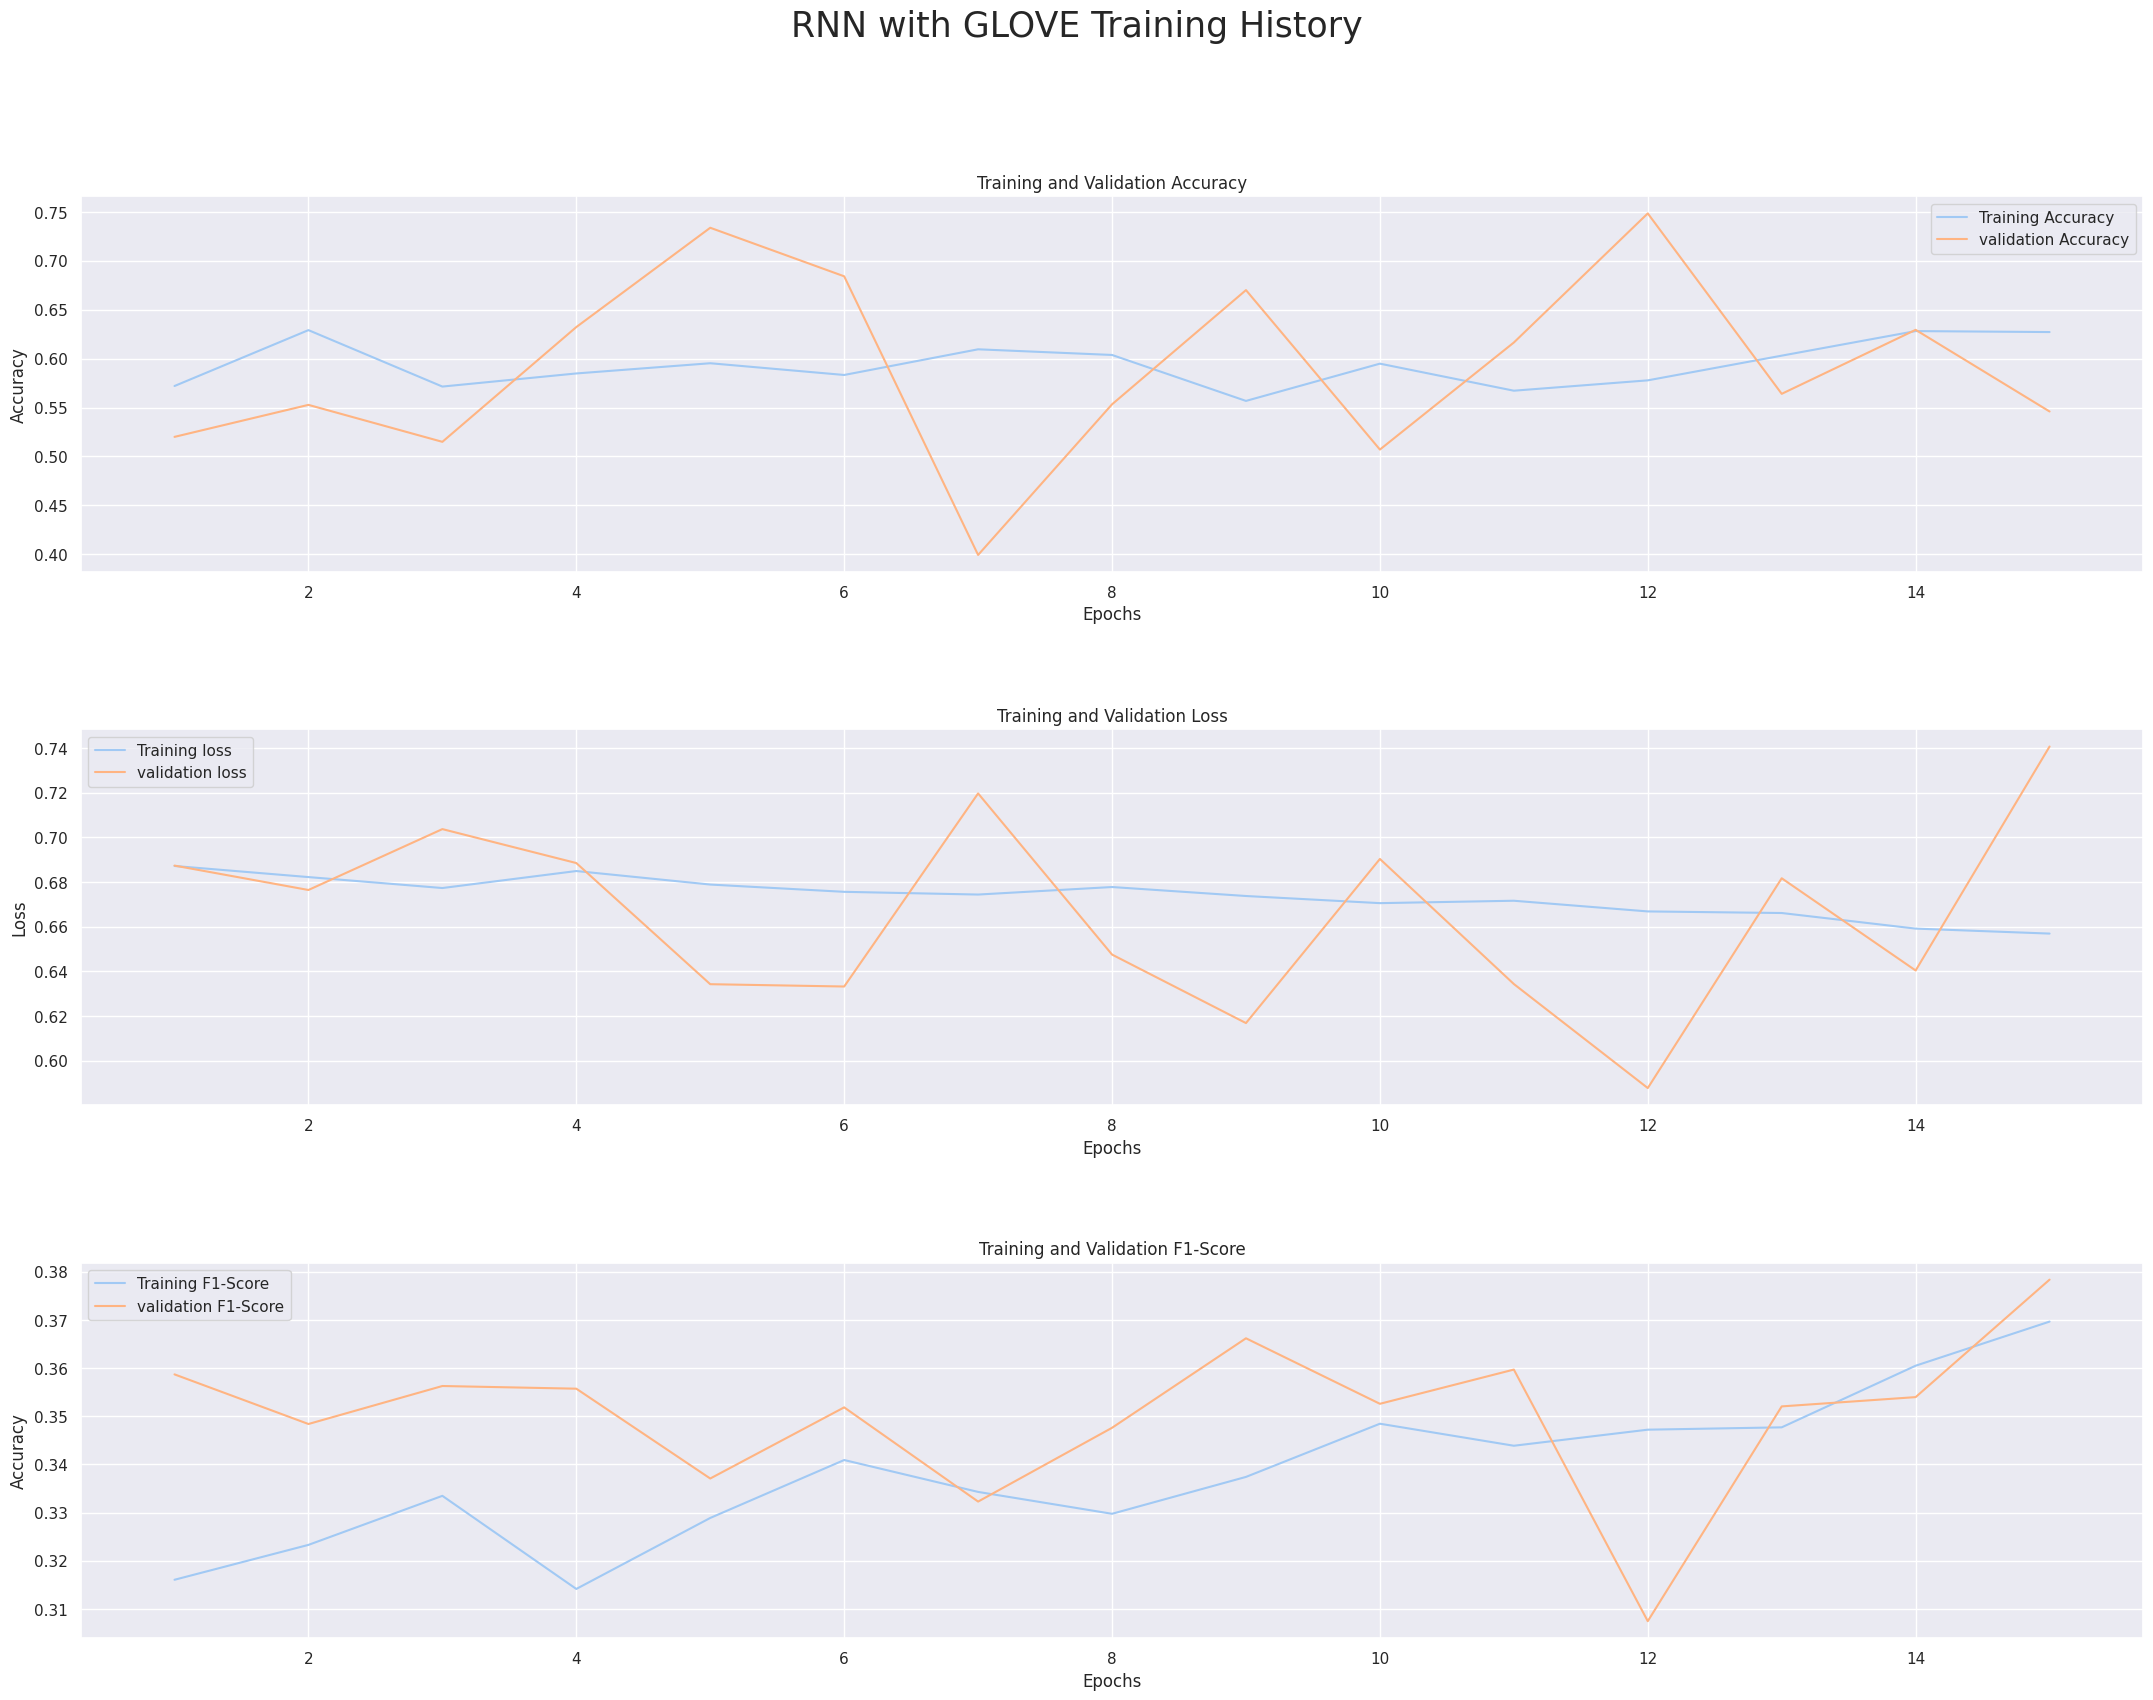

In [150]:
#plotting results
fig, axes = plt.subplots(3,1, figsize = (23,18))

sns.lineplot(data=result, x = 'epochs', y = 'accuracy', ax=axes[0],label='Training Accuracy')
sns.lineplot(data=result, x = 'epochs', y= 'val_accuracy', ax=axes[0], label = 'validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

sns.lineplot(data=result, x = 'epochs', y = 'loss', ax=axes[1],label='Training loss')
sns.lineplot(data=result, x = 'epochs', y= 'val_loss', ax=axes[1], label = 'validation loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

sns.lineplot(data=result, x = 'epochs', y = 'f1_score', ax=axes[2],label='Training F1-Score')
sns.lineplot(data=result, x = 'epochs', y= 'val_f1_score', ax=axes[2], label = 'validation F1-Score')
axes[2].set_title('Training and Validation F1-Score')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

plt.suptitle('RNN with GLOVE Training History', fontsize=25)
plt.tight_layout(pad=5.0)
plt.show()

In [151]:
#classification report
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5)

print(classification_report(y_test,y_pred))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1811
         1.0       0.32      0.32      0.32       405

    accuracy                           0.75      2216
   macro avg       0.58      0.58      0.58      2216
weighted avg       0.75      0.75      0.75      2216



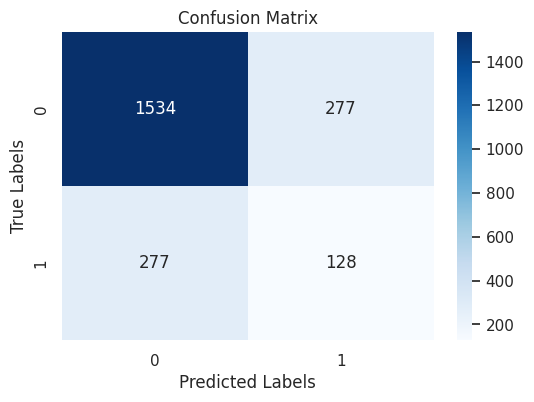

In [152]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# RNN with Fasttext

In [153]:
#splitting into list of tokens
df['text'] = df['text'].apply(lambda x: x.split())

In [ ]:
#creating fasttext model
fasttext = FastText(
    sentences=df['text'],
    vector_size=EMBED_DIM,
    window=5,
    sg=1,
    min_count=5,
    epochs=30,
    workers=4
)


In [155]:
#function to vectorize using fasttext
def vectorize_text_fasttext(text,model,embed_dim=EMBED_DIM):
    return [model.wv[word] if word in model.wv else np.zeros(embed_dim) for word in text]

In [156]:
# vectorize the text data using fasttext
X_fasttext = [vectorize_text_fasttext(tokens,fasttext,EMBED_DIM) for tokens in df['text']]
y = df['target'].values

In [157]:
# padding the sequences
X_padded = pad_sequences(X_fasttext,maxlen=SEQ_LEN,padding='post', truncating='post')
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [158]:
#converting y to fload and expanding dims for computing f1score
y_train =y_train.astype(np.float32)
y_train = tf.expand_dims(y_train,axis=1)

y_test =y_test.astype(np.float32)
y_test = tf.expand_dims(y_test,axis=1)

In [159]:
#building model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN,EMBED_DIM)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False)),

    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.F1Score(average='weighted',threshold = 0.5)])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_21                │ (None, 100, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,273 (837.00 KB)

 Trainable params: 214,273 (837.00 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
#training model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACTS_DIR,'fasttext_rnn_model.keras'),
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(X_train,y_train,batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, class_weight=dict_weights, callbacks=callbacks)

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6176 - f1_score: 0.4061 - loss: 0.6293 - val_accuracy: 0.8302 - val_f1_score: 0.5541 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7534 - f1_score: 0.5209 - loss: 0.5214 - val_accuracy: 0.7389 - val_f1_score: 0.5131 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7800 - f1_score: 0.5681 - loss: 0.4909 - val_accuracy: 0.7862 - val_f1_score: 0.5439 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7805 - f1_score: 0.5714 - loss: 0.4785 - val_accuracy: 0.7682 - val_f1_score: 0.5366 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7938 - f1_score: 0.5954 - loss: 0.4540 - val_accuracy: 0.7817 - val_f1_score: 0.5387 - val_loss: 0.4766 - learning_rate: 7.0000e-04
Epoch 6/15
222/222 ━

In [161]:
result = pd.DataFrame(history.history)
result['epochs'] = result.index + 1

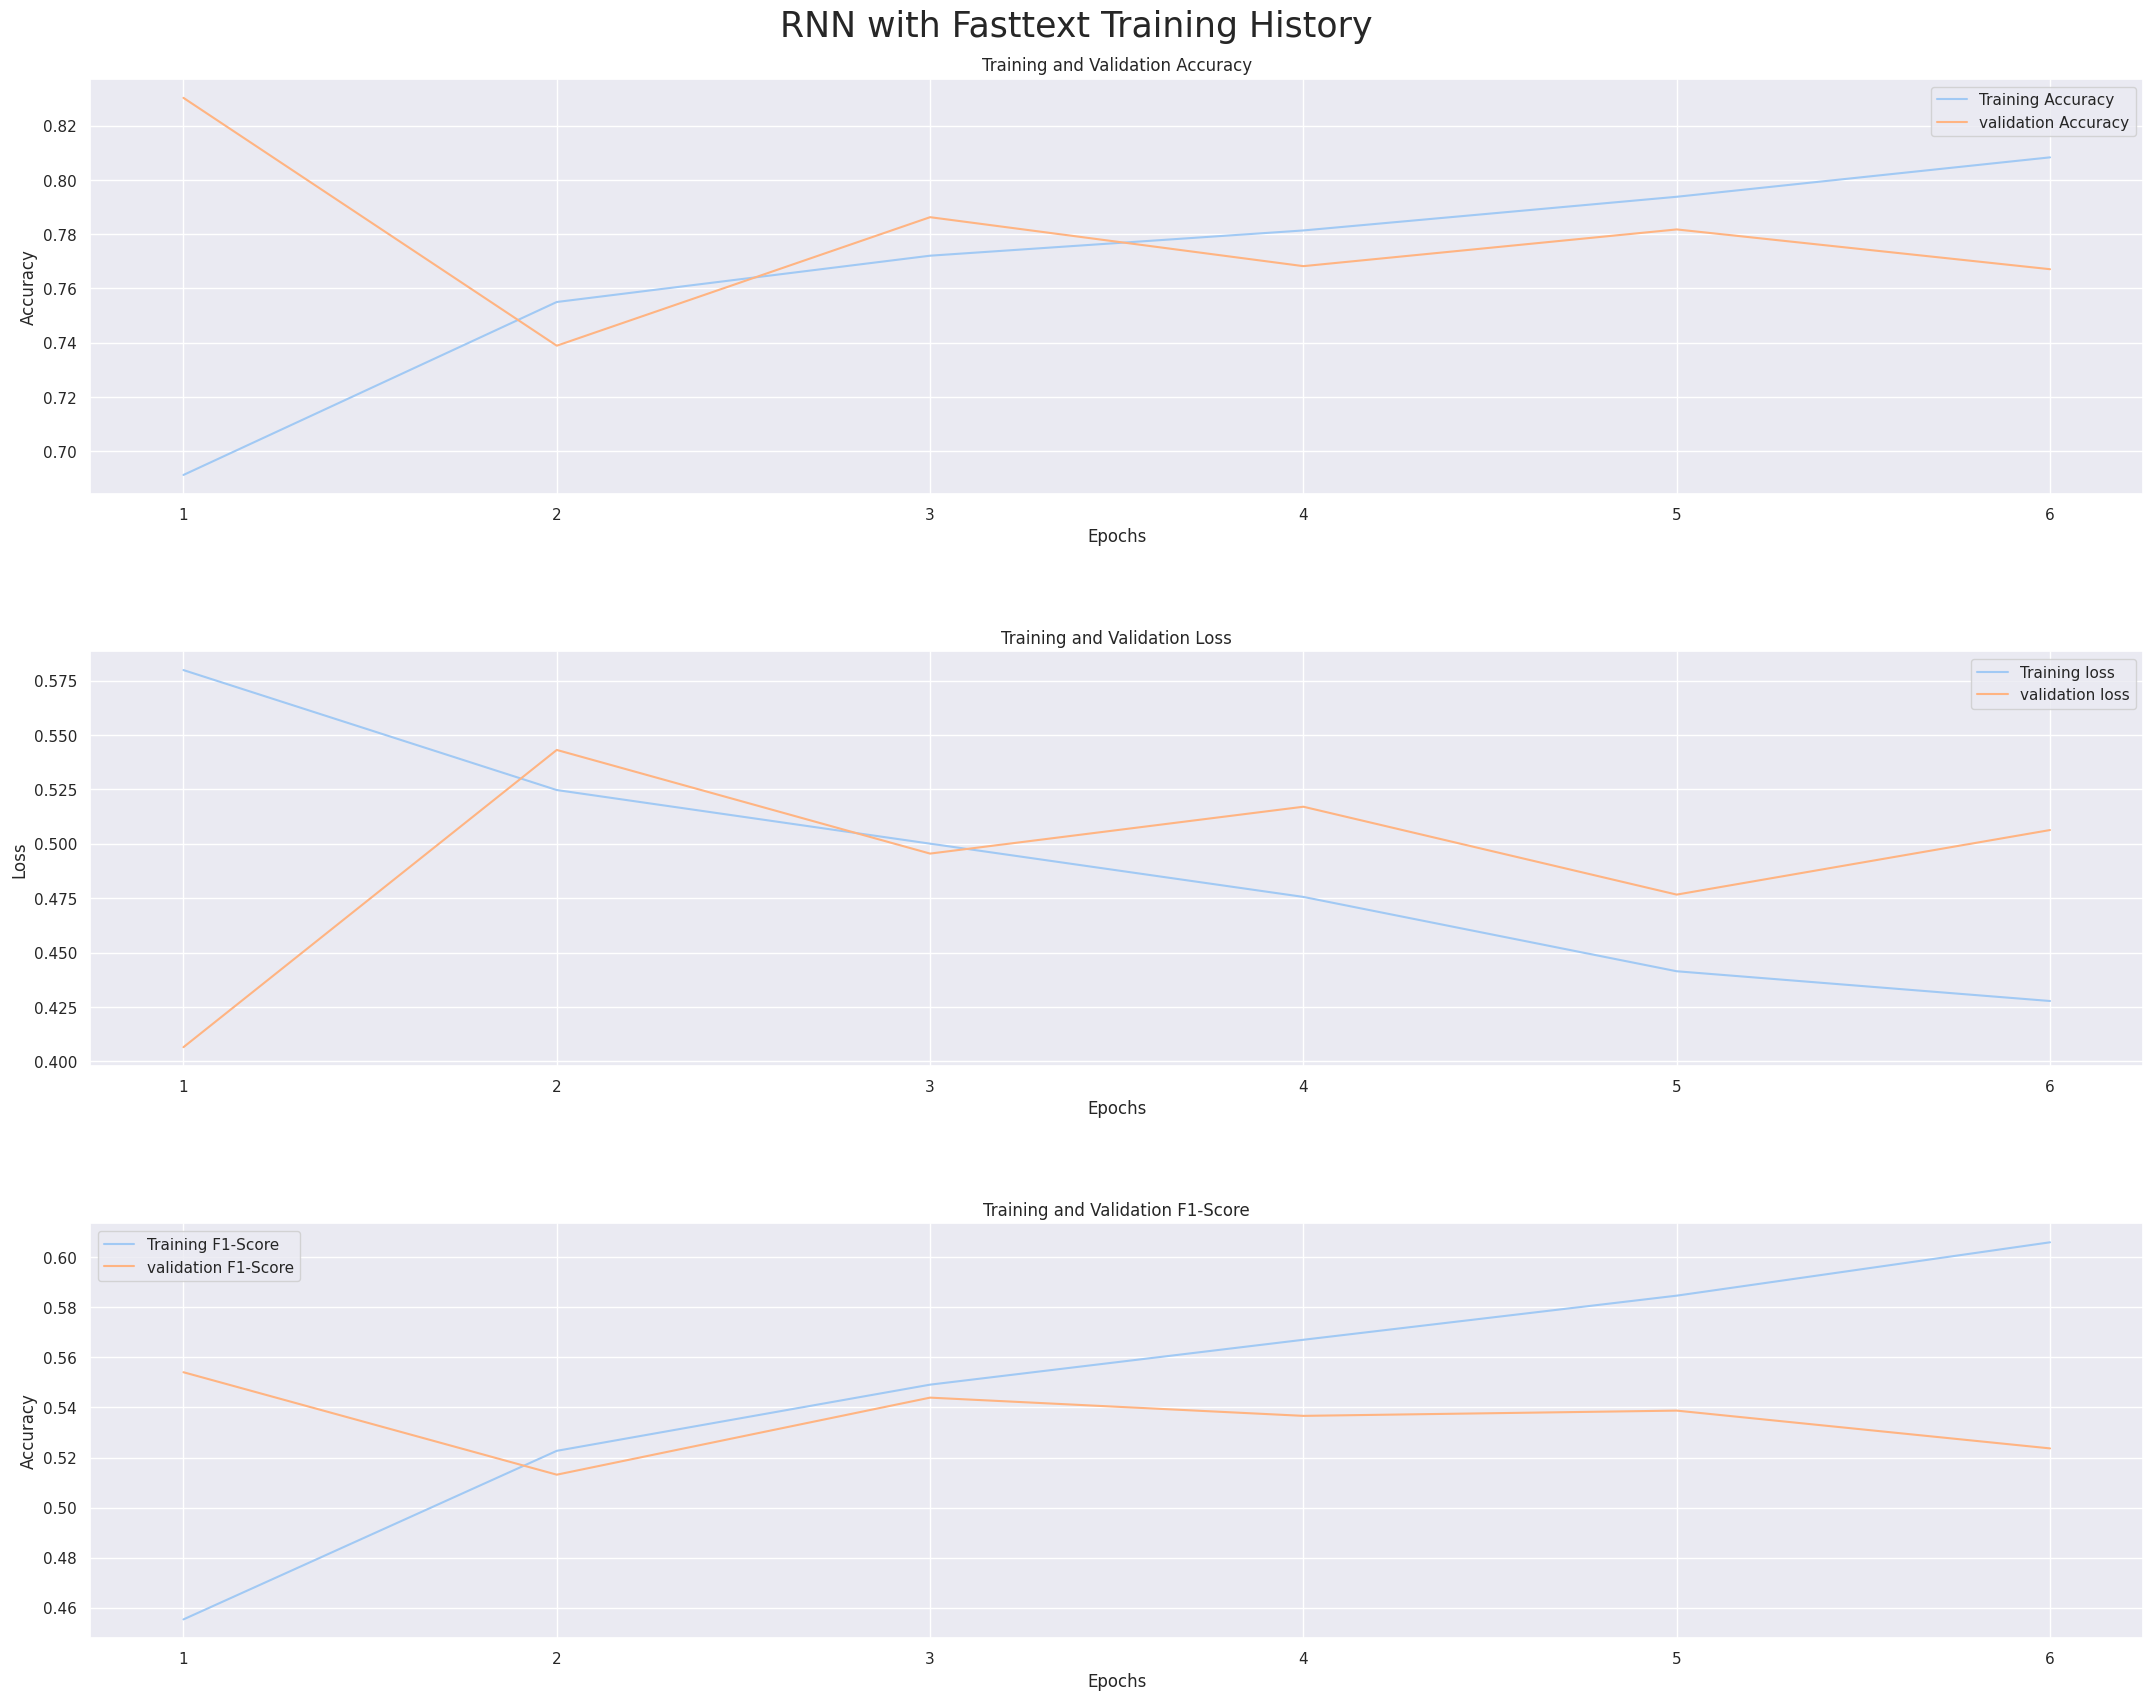

In [162]:
#plotting results
fig, axes = plt.subplots(3,1, figsize = (23,18))


sns.lineplot(data=result, x = 'epochs', y = 'accuracy', ax=axes[0],label='Training Accuracy')
sns.lineplot(data=result, x = 'epochs', y= 'val_accuracy', ax=axes[0], label = 'validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

sns.lineplot(data=result, x = 'epochs', y = 'loss', ax=axes[1],label='Training loss')
sns.lineplot(data=result, x = 'epochs', y= 'val_loss', ax=axes[1], label = 'validation loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

sns.lineplot(data=result, x = 'epochs', y = 'f1_score', ax=axes[2],label='Training F1-Score')
sns.lineplot(data=result, x = 'epochs', y= 'val_f1_score', ax=axes[2], label = 'validation F1-Score')
axes[2].set_title('Training and Validation F1-Score')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

plt.tight_layout(pad=5.0)
plt.suptitle('RNN with Fasttext Training History', fontsize=25)
plt.show()

In [163]:
#classification report
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5)

print(classification_report(y_test,y_pred))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      1811
         1.0       0.49      0.55      0.52       405

    accuracy                           0.81      2216
   macro avg       0.70      0.71      0.70      2216
weighted avg       0.82      0.81      0.82      2216



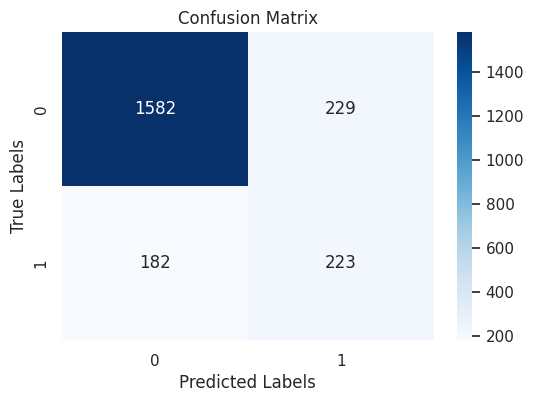

In [164]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# RNN with Embedding Layer and Keras tokenizer

In [ ]:
#tokenizing tokens into numbers
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['text'])
X_tokenized = tokenizer.texts_to_sequences(df['text'])


#save the tokenizer
with open(os.path.join(ARTIFACTS_DIR,'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [166]:
#padding the sequences
X_padded = pad_sequences(X_tokenized, maxlen=SEQ_LEN,padding = 'post', truncating='post')
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [167]:
#converting y to fload and expanding dims for computing f1score
y_train =y_train.astype(np.float32)
y_train = tf.expand_dims(y_train,axis=1)

y_test =y_test.astype(np.float32)
y_test = tf.expand_dims(y_test,axis=1)

In [168]:
#building model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN,)),
    tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=SEQ_LEN),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,return_sequences=False)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics =['accuracy',tf.keras.metrics.F1Score(average='weighted',threshold=0.5)])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 16)             │         6,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,201 (2.47 MB)

 Trainable params: 647,201 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#training model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACTS_DIR,'rnn_embedding_model.keras'),
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(X_train,y_train,batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, class_weight=dict_weights, callbacks=callbacks)

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4142 - f1_score: 0.3108 - loss: 0.6933 - val_accuracy: 0.7406 - val_f1_score: 0.4989 - val_loss: 0.6747 - learning_rate: 0.0010
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7435 - f1_score: 0.5093 - loss: 0.6389 - val_accuracy: 0.8274 - val_f1_score: 0.6127 - val_loss: 0.5031 - learning_rate: 0.0010
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8345 - f1_score: 0.6534 - loss: 0.4576 - val_accuracy: 0.8223 - val_f1_score: 0.6182 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8759 - f1_score: 0.7077 - loss: 0.3452 - val_accuracy: 0.8291 - val_f1_score: 0.6245 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9064 - f1_score: 0.7797 - loss: 0.2679 - val_accuracy: 0.8652 - val_f1_score: 0.6703 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 6/15
222/222 ━━━━━━

In [170]:
result = pd.DataFrame(history.history)
result['epochs'] = result.index + 1

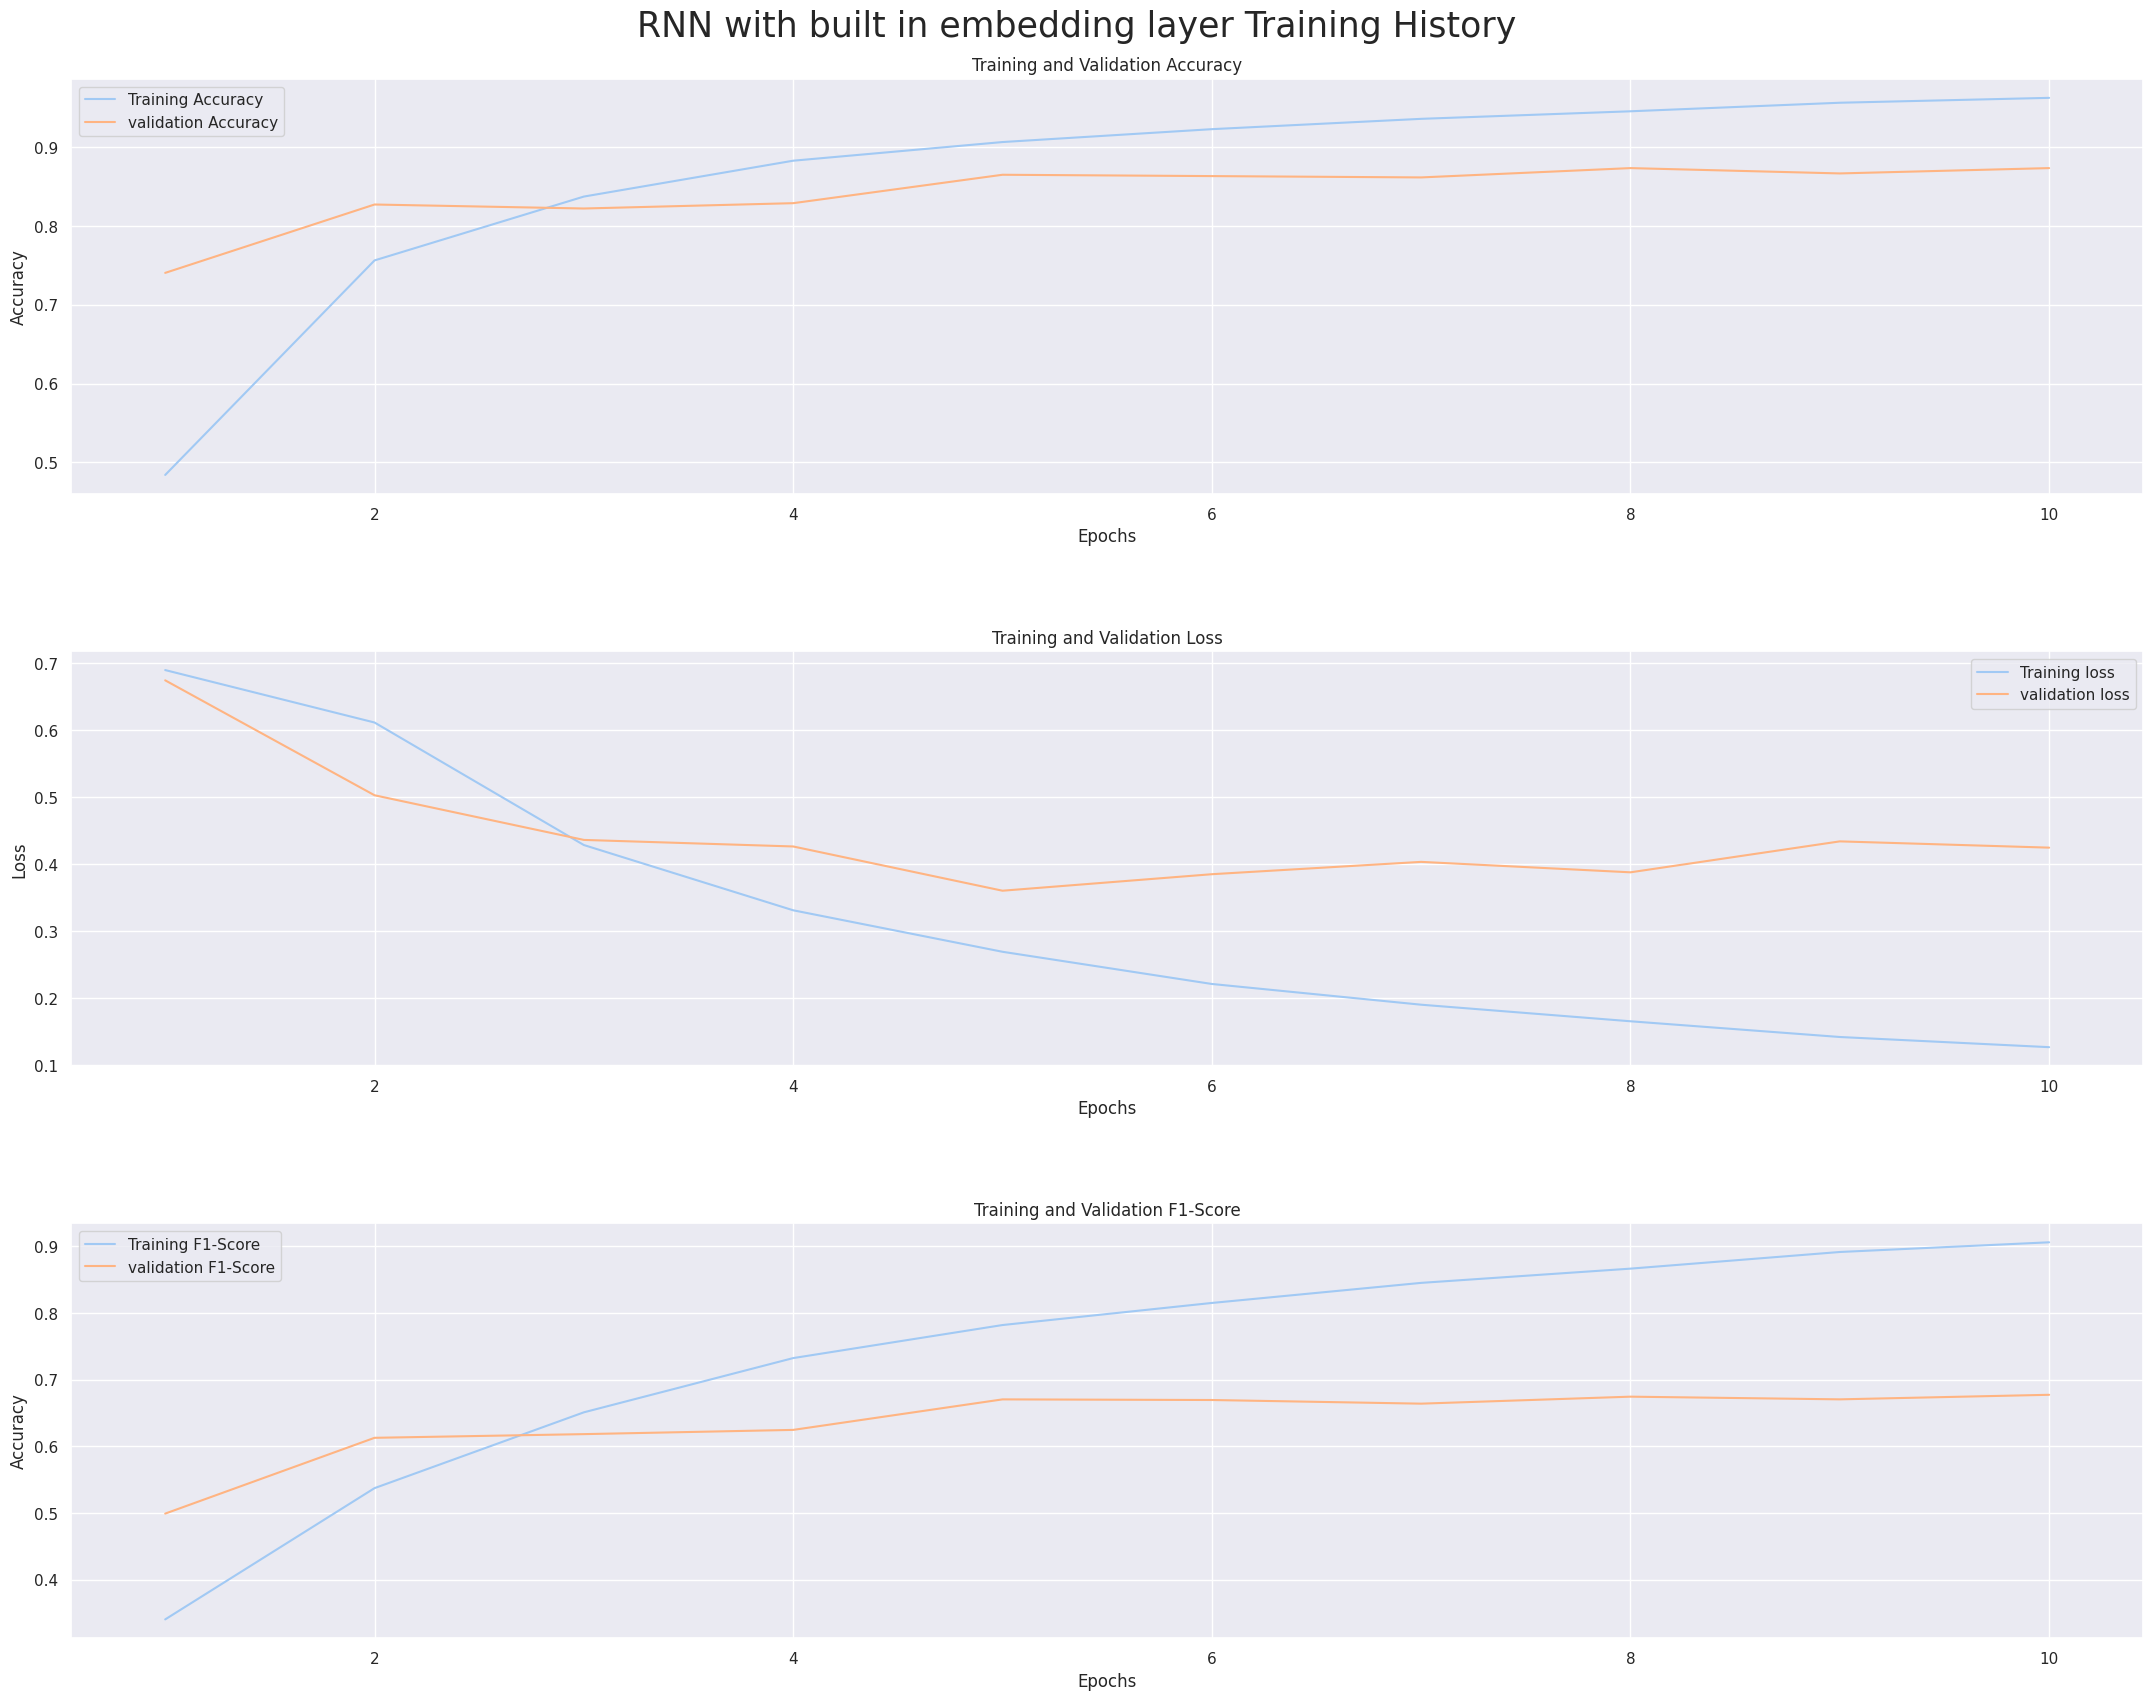

In [171]:
#plotting results
fig, axes = plt.subplots(3,1, figsize = (23,18))


sns.lineplot(data=result, x = 'epochs', y = 'accuracy', ax=axes[0],label='Training Accuracy')
sns.lineplot(data=result, x = 'epochs', y= 'val_accuracy', ax=axes[0], label = 'validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

sns.lineplot(data=result, x = 'epochs', y = 'loss', ax=axes[1],label='Training loss')
sns.lineplot(data=result, x = 'epochs', y= 'val_loss', ax=axes[1], label = 'validation loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

sns.lineplot(data=result, x = 'epochs', y = 'f1_score', ax=axes[2],label='Training F1-Score')
sns.lineplot(data=result, x = 'epochs', y= 'val_f1_score', ax=axes[2], label = 'validation F1-Score')
axes[2].set_title('Training and Validation F1-Score')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

plt.tight_layout(pad=5.0)
plt.suptitle('RNN with built in embedding layer Training History', fontsize=25)
plt.show()

In [172]:
#classification report
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5)

print(classification_report(y_test,y_pred))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      1811
         1.0       0.59      0.71      0.65       405

    accuracy                           0.86      2216
   macro avg       0.76      0.80      0.78      2216
weighted avg       0.87      0.86      0.86      2216



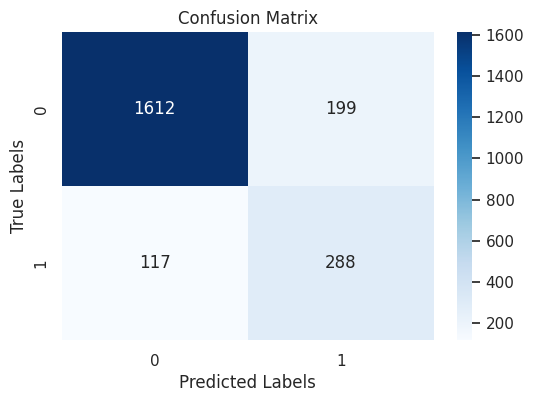

In [173]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()